# Introduction to RNNs: learning the alphabet

A simple example to understand how Recurrent Neural Networks learn sequential patterns.

## Key concepts

- **Sequence learning**: RNNs process input one step at a time, maintaining a "memory" (hidden state) of what they've seen.
- **Next-character prediction**: Given a sequence like `['a', 'b', 'c']`, predict the next character (`'d'`).
- **Hidden state**: The internal memory that carries information from previous timesteps (or indexes) in a sequence.

## How the RNN processes a sequence

Given input `['a', 'b', 'c']`, the RNN predicts `'d'`:

```text

                     ┌─◀──────┐ 'h₁', then 'h₂'
                     │        ▲ 
                     ▼        |
                    ┌──────────┐
                    |   RNN    |         ┌───────┐
'a', then 'b', ────▶| (hidden  |──'h₃'──▶│ Dense │───▶ 'c'
   then 'c'         | state h) |         └───────┘ 
                    └──────────┘


h₁ = RNN('a', h₀)        # h₁ "knows" about 'a'
h₂ = RNN('b', h₁)        # h₂ "knows" about 'a', 'b'  
h₃ = RNN('c', h₂)        # h₃ "knows" about 'a', 'b', 'c'
output = Dense(h₃) → 'd' # Final hidden state predicts next char
```

The same RNN weights are used at each step within a sequence — only the hidden state changes.

## Setup

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.utils import to_categorical

### Configuration

In [2]:
epochs=300
batch_size=4

# Force CPU only
tf.config.set_visible_devices([], 'GPU')

## 1. Data preparation

### 1.1. Create the alphabet dataset

In [3]:
# Create alphabet mapping
alphabet = 'abcdefghijklmnopqrstuvwxyz'
char_to_idx = {c: i for i, c in enumerate(alphabet)}
idx_to_char = {i: c for i, c in enumerate(alphabet)}
vocab_size = len(alphabet)

print(f'Vocabulary: {alphabet}')

print('\nMappings:\n')

for key, val in char_to_idx.items():
    print(f' {key} -> {val}')

Vocabulary: abcdefghijklmnopqrstuvwxyz

Mappings:

 a -> 0
 b -> 1
 c -> 2
 d -> 3
 e -> 4
 f -> 5
 g -> 6
 h -> 7
 i -> 8
 j -> 9
 k -> 10
 l -> 11
 m -> 12
 n -> 13
 o -> 14
 p -> 15
 q -> 16
 r -> 17
 s -> 18
 t -> 19
 u -> 20
 v -> 21
 w -> 22
 x -> 23
 y -> 24
 z -> 25


### 1.2. Training 'freatures' & labels

In [4]:
seq_length = 3

y = alphabet[seq_length:] + 'a'  # Wrap around: 'xyz' -> 'a'
x = list(zip(*[alphabet[i:] for i in range(seq_length)]))

print('\nInput sequence  -> label')

for features, label in zip(x, y):
    print(f'{features} -> {label}')

print(f'X shape: {np.array(x).shape}, y shape: {np.array(list(y)).shape}')


Input sequence  -> label
('a', 'b', 'c') -> d
('b', 'c', 'd') -> e
('c', 'd', 'e') -> f
('d', 'e', 'f') -> g
('e', 'f', 'g') -> h
('f', 'g', 'h') -> i
('g', 'h', 'i') -> j
('h', 'i', 'j') -> k
('i', 'j', 'k') -> l
('j', 'k', 'l') -> m
('k', 'l', 'm') -> n
('l', 'm', 'n') -> o
('m', 'n', 'o') -> p
('n', 'o', 'p') -> q
('o', 'p', 'q') -> r
('p', 'q', 'r') -> s
('q', 'r', 's') -> t
('r', 's', 't') -> u
('s', 't', 'u') -> v
('t', 'u', 'v') -> w
('u', 'v', 'w') -> x
('v', 'w', 'x') -> y
('w', 'x', 'y') -> z
('x', 'y', 'z') -> a
X shape: (24, 3), y shape: (24,)


### 1.3. One-hot encoding

In [5]:
X_indices = np.array([[char_to_idx[c] for c in seq] for seq in x])
y_indices = np.array([char_to_idx[c] for c in y])

X_onehot = to_categorical(X_indices, num_classes=vocab_size)
y_onehot = to_categorical(y_indices, num_classes=vocab_size)

print('First sequence (one-hot):')

for ele in X_onehot[0][:, :10]:
    print(f' {(", ").join(map(str, ele))}...')

print('\nFirst label (one-hot):')
print(f' {(", ").join(map(str, y_onehot[0][:10]))}...')

print(f'\nX shape (one-hot): {X_onehot.shape}')
print(f'y shape (one-hot): {y_onehot.shape}')

First sequence (one-hot):
 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...

First label (one-hot):
 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...

X shape (one-hot): (24, 3, 26)
y shape (one-hot): (24, 26)


## 2. Recurrent model

A simple architecture:
1. **Input**: One-hot encoded characters (26-dimensional vectors)
2. **SimpleRNN**: Process the sequence, output final hidden state  
3. **Dense**: Predict the next character

With one-hot encoding, each input character is a vector of 26 zeros with a single 1 at the character's index position.

### 2.1. Define RNN

In [6]:
# Model parameters
hidden_dim = 8 # RNN hidden state size

model = Sequential([
    SimpleRNN(hidden_dim, input_shape=(seq_length, vocab_size)),
    Dense(vocab_size, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 280       
                                                                 
 dense (Dense)               (None, 26)                234       
                                                                 
Total params: 514 (2.01 KB)
Trainable params: 514 (2.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 2.2. Train RNN

In [7]:
history = model.fit(
    X_onehot, y_onehot,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)

I0000 00:00:1771281877.304733  645467 service.cc:145] XLA service 0x780ed4008aa0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771281877.304775  645467 service.cc:153]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1771281877.374008  645476 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


### 2.3. Learning curves

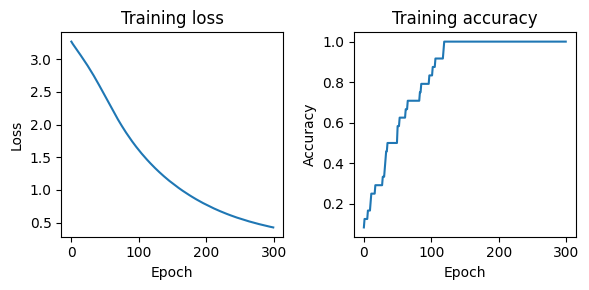

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].plot(history.history['loss'])
axes[0].set_title('Training loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

axes[1].plot(history.history['accuracy'])
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

## 3. Model evaluation

In [9]:
def predict_next(chars, model):
    '''Predict the next character given a sequence.'''

    indices = np.array([[char_to_idx[c] for c in chars]])
    onehot = to_categorical(indices, num_classes=vocab_size)
    pred = model.predict(onehot, verbose=0)
    next_idx = np.argmax(pred)

    return idx_to_char[next_idx]

In [10]:
# Test predictions
test_sequences = ['abc', 'def', 'mno', 'stu', 'wxy']

print('Predictions:')

for seq in test_sequences:
    if len(seq) == seq_length and all(c in char_to_idx for c in seq):
        pred = predict_next(seq, model)
        print(f' {seq} -> {pred}')

Predictions:
 abc -> d
 def -> g
 mno -> p
 stu -> v
 wxy -> z
